In [1]:
%run pylib/ml_fit dr4 show dark title "BCU issue"
import warnings
warnings.filterwarnings("ignore")
self, dfc = kde_setup('d log_epeak diffuse'.split())
palette = self.palette

# BCU issue

<h5 style="text-align:right; margin-right:15px"> 2024-04-08 14:09</h5>

Not applying ML, so no class fits to generate prediction model. Instead we compute KDE probability density distributions
for the ML trainers, which we then apply to the unid and bcu associations.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f06117ef760>

### Data selection cut: "0.15<Ep<4 & d>0.2 & variability<25"

subset,blazar,psr,msp,unid
total,2283,140,176,2349
selected,162,128,169,1389
%,7,91,96,59


## Create KDE functions instead of ML training
* Classes: psr, msp, blazar
* Features: d, log_epeak, diffuse 

Apply to unids 

In [2]:
show("""
## On understanding the BCU's

Up to now, the BCU component of the 4FGL catalogs has been a bit of a mystery to me. The reason was that I naively presumed that there was a counterpart that was a blazar of undetermined type. But there is a component of around 200 sources (out of 1626) that do not match the blazar spectral shape characteristics. This set also appears to be Galactic according to position. 

Now I realize that this category is mostly defined by a *radio* association, and that radio sources are presumed to be galaxies. But complicating this is the fact that there are actually 42 counterpart catalogs for the BCU and UNK sets. Many of these were added using a follow-on procedure as described in the last five paragraphs of Section 5 of the [4FGL paper]((https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/4FGL_Catalog_accepted.pdf)). The alternate LR association procedure is described here.

The largest counterpart catalog is NVSS. These entries are only accepted if $|b|>10^\circ$, with the remainder relegated to the UNK category. Since I've been adding these to my "unid" set, it makes sense to include BCUs as will.

A final revelation: BCU sources defined by an association to a radio source with no additional information may in fact be MSPs!
""")

## On understanding the BCU's

Up to now, the BCU component of the 4FGL catalogs has been a bit of a mystery to me. The reason was that I naively presumed that there was a counterpart that was a blazar of undetermined type. But there is a component of around 200 sources (out of 1626) that do not match the blazar spectral shape characteristics. This set also appears to be Galactic according to position. 

Now I realize that this category is mostly defined by a *radio* association, and that radio sources are presumed to be galaxies. But complicating this is the fact that there are actually 42 counterpart catalogs for the BCU and UNK sets. Many of these were added using a follow-on procedure as described in the last five paragraphs of Section 5 of the [4FGL paper]((https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/4FGL_Catalog_accepted.pdf)). The alternate LR association procedure is described here.

The largest counterpart catalog is NVSS. These entries are only accepted if $|b|>10^\circ$, with the remainder relegated to the UNK category. Since I've been adding these to my "unid" set, it makes sense to include BCUs as will.

A final revelation: BCU sources defined by an association to a radio source with no additional information may in fact be MSPs!

### ECDF plots for the KDE probability densities

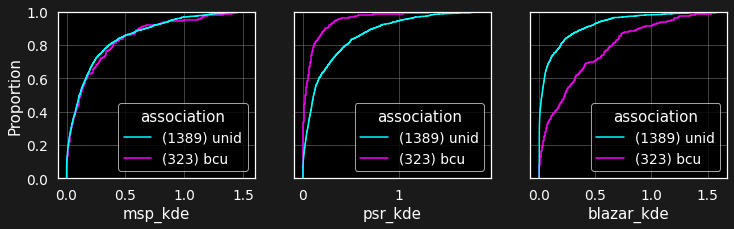

In [3]:
show(f"""### ECDF plots for the KDE probability densities""")
fig, axx = plt.subplots(ncols=3, figsize=(12,3), sharey=True)
data = dfc.query('4>Ep>0.1 & d>0.2')
for t, ax  in zip('msp psr blazar'.split(), axx.flat):
    sns.ecdfplot(data, ax=ax, x=t+'_kde', # element='step', bins=50,
                hue='association', hue_order='unid bcu'.split(), palette=palette[:2] );
    from pylib.tools import update_legend
    update_legend(ax, data, 'association')

In [26]:
def add_assinfo(df):
    from pylib.catalogs import Fermi4FGL
    from astropy.coordinates import SkyCoord
    global fgl
    if 'fgl' not in globals():
        fgl = Fermi4FGL()
    subset = np.isin(fgl.index, df.index)
    bay,lr = [fgl.field(t).astype(float)[subset] for t in 'ASSOC_PROB_BAY ASSOC_PROB_LR'.split()]
    df['assoc1'] = [s.strip() for s in fgl.field('ASSOC1')[subset]]
    df['Bayes']= bay; 
    df['LR'] = lr
    df.Bayes[pd.isna(df.Bayes)]=0.5
    for name in 'RA_Counterpart DEC_counterpart Unc_Counterpart'.split():
        df[name.lower()] = fgl.field(name)[subset].astype(np.float32)

    sky_fgl = fgl.skycoord[subset]
    sky_cp = SkyCoord(df.ra_counterpart, df.dec_counterpart, unit='deg', frame='fk5')
    df['dist'] = sky_fgl.separation(sky_cp).deg.clip(0,0.5)
add_assinfo(dfc)

kent_df = dfc.query('class1=="bcu" | class1=="unk"')['glat glon r95 Ep d Bayes LR class1 assoc1 dist msp_kde'.split()]
kent_df
kent_df['catid'] = kent_df.assoc1.apply(lambda s: s.split()[0])

In [27]:
show("""CLASS1 contents of kent_df""")
show(pd.Series(kent_df.groupby('class1').size(), name='# sources'))

CLASS1 contents of kent_df

class1,bcu,unk
# sources,323,79


In [28]:
show(f"""### Table of associated catalogs vs association type""")
ass_key = [ 'Bayes>0.5 & LR==0', 'LR>0 & Bayes==0', 'LR>0 & Bayes>0','Bayes==0.5', 'Total']
catx = []
for k in ass_key:
    catx.append(pd.Series((kent_df if k=='Total' else kent_df.query(k))
                          .groupby('catid').size().fillna(0), name=k)
               )
catid_df = pd.DataFrame(catx).fillna(0).T.astype(int)
show(catid_df.sort_values('Total', ascending=False))
show(f'Length: {len(catid_df)}' )
# cats, len(cats), sum(cats), len(fgl.query('class1=="bcu"'))

### Table of associated catalogs vs association type

,Bayes>0.5 & LR==0,LR>0 & Bayes==0,LR>0 & Bayes>0,Bayes==0.5,Total
catid,,,,,
NVSS,26,26,12,28,92
PMN,23,3,38,1,65
1RXS,2,35,3,0,40
TXS,6,7,16,1,30
PKS,6,4,18,0,28
GB6,10,0,6,2,18
AT20G,2,3,10,0,15
87GB,8,1,2,0,11
2MASS,8,1,0,1,10


Length: 41

### Check association offsets

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f6ad29718d0>
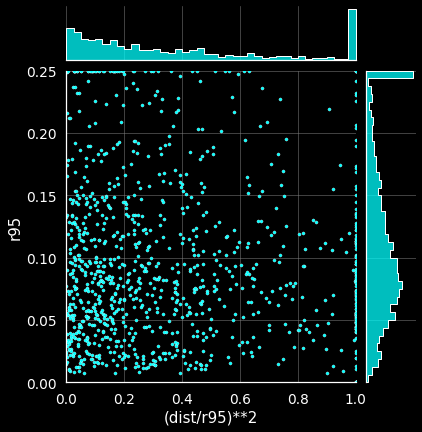

Conclude that looks like expected exponential

In [29]:
show(f"""### Check association offsets""")

jp=sns.jointplot(dfc, #kent_df,  
                 y=dfc.r95.clip(0,0.25), x=(dfc.dist/dfc.r95).clip(0,1)**2,

                 s=10, color='cyan', height=6,
             marginal_kws=dict(bins=40, element='step', edgecolor='w')
                );
jp.ax_joint.set(ylim=(0,0.25), xlim=(0,1), xlabel='(dist/r95)**2');
show(jp.figure)
show("""Conclude that looks like expected exponential""")
# ax.plot(lim, lim, 'r--');

In [36]:
with pd.option_context('display.precision',3):
    show(kent_df.query('-10<glat<10 & d>1.4'))

,glat,glon,r95,Ep,d,Bayes,LR,class1,assoc1,dist,msp_kde,catid
4FGL-DR4,,,,,,,,,,,,
4FGL J0135.0+5338,-8.684,129.447,0.122,1.066,1.448,0.987,0.808,bcu,LQAC 023+053,0.016,1.678e-01,LQAC
4FGL J0711.3-0942,-0.049,223.836,0.194,0.481,1.741,0.000,0.860,unk,TXS 0709-096,0.094,2.961e-02,TXS
4FGL J0745.4-2447,-0.150,240.963,0.457,0.338,1.950,0.846,0.000,bcu,PMN J0745-2451,0.089,1.147e-04,PMN
4FGL J1256.1-5652,5.994,303.574,0.096,0.510,1.461,0.000,0.904,unk,1RXS J125554.2-564945,0.051,7.425e-02,1RXS
4FGL J1628.3-4500,2.605,337.973,0.118,0.965,1.497,0.000,0.848,unk,1RXS J162834.6-450035,0.047,9.735e-02,1RXS
4FGL J1657.2-4020,1.661,344.989,0.102,1.762,1.620,0.000,0.816,unk,AT20G J165647-401424,0.133,3.167e-02,AT20G
4FGL J1718.3-3001,4.386,355.840,0.102,0.904,1.619,0.000,0.884,unk,NVSS J171812-300141,0.021,6.019e-02,NVSS
4FGL J1720.0-5101,-7.884,338.757,0.285,0.331,1.937,0.914,0.000,bcu,PMN J1721-5055,0.211,3.284e-05,PMN
4FGL J1743.9-1824,5.802,8.803,0.098,0.897,1.713,0.931,0.860,bcu,PMN J1743-1828,0.083,3.756e-02,PMN


In [50]:
kent_psr="""\
4FGL J0711.3-0942	
4FGL J1628.3-4500	
4FGL J1718.3-3001	
4FGL J1720.0-5101	
4FGL J1743.9-1824	
4FGL J2003.6+2333""".split('\t\n'); kent_psr	
sel = kent_df.loc[kent_psr, 'msp_kde']
sel.mean(), kent_df.query('-10<glat<10 & d>1.4').msp_kde.mean()


(0.06747448010872119, 0.04673702710799266)

In [21]:
show(f"""Create file `{(kent_file:="files/kent_df.csv")}`""")
kent_df.to_csv(kent_file, float_format="%.3f")

Create file `files/kent_df.csv`

In [51]:
def hist_kde(self,df, axx):
    """Histograms of the blazar KDE values...
    """
    data = df.copy()
    def hist_blazar_kde( ax):
        data['blazar class']= data.association
        sns.histplot(data, ax=ax, x='blazar_kde', hue='blazar class',
                     hue_order='bll fsrq bcu'.split(), palette=self.palette,
                     element='step')
        ax.set(xticks=np.arange(0,1.51, 0.5), xlabel='blazar KDE')
     
    def hist_pulsar_kde( ax):
        data['pulsar class']= data.association
        sns.histplot(data, ax=ax, x='blazar_kde', hue='pulsar class',
                     hue_order='psr msp'.split(), palette=self.palette,
                     element='step')
        ax.set(xticks=np.arange(0,1.51, 0.5), xlabel='blazar KDE')

    hist_blazar_kde( ax=axx[0])
    hist_pulsar_kde( ax=axx[1])
    return fig

### Blazar KDE for blazar and pulsar types
The KDE for blazars is determined from the `bll` and `fsrq` classes. Here we 
examine distributions
of it for the blazar types, including also `bcu`, and the pulsar types.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f6ad27f4a30>
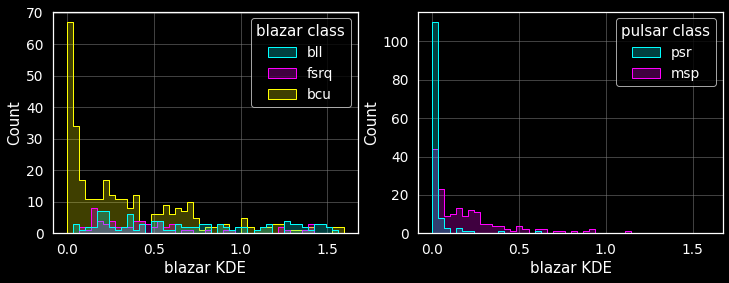

Note that the `bcu` has a component that does not correspond to that
expected for the known blazar types. The pulsars show show small 
values of the blazar KDE, but there is a little mixing for `msp`. 

In [52]:
fig, axx = plt.subplots(ncols=2, figsize=(12,4))   
show(f"""### Blazar KDE for blazar and pulsar types
The KDE for blazars is determined from the `bll` and `fsrq` classes. Here we 
examine distributions
of it for the blazar types, including also `bcu`, and the pulsar types.
""")

show_fig(hist_kde, self, dfc, axx, )
show(f"""Note that the `bcu` has a component that does not correspond to that
expected for the known blazar types. The pulsars show show small 
values of the blazar KDE, but there is a little mixing for `msp`. 
""")

## Look at $d$ vs diffuse for bcu
Blazars with a known type are isotropic, and have small curvatures.
The former corresponds to small values for the diffuse parameter. The bcu's on the other hand,
populate much more of this space, as is seen below:

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f6acada38e0>
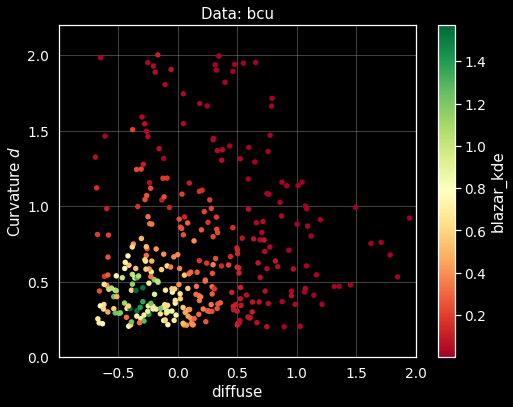

The colors correspond to the KDE determination for the 162 actual blazars which survived the
initial selection.

In [65]:
def d_vs_diffuse(df, which='bcu', kde='blazar'):
    

    fig, ax = plt.subplots(figsize=(8,6))
    data = df.query(f'subset=="{which}"')
    
    assert len(data)>0, f'No data selected with {which}'
    data_kw = dict(data=data,
                  s=30, edgecolor='none',c=data[kde+'_kde'], cmap='RdYlGn',# color='maroon', 
                  label=which) 
    ax.set( ylim=(0.,2.2), title=f'Data: {which}',
           yticks=np.arange(0.,2.1,0.5), ylabel='Curvature ${d}$' )
    ax.set(xlim=(-1,2.), xticks=np.arange(-0.5,2.1,0.5),  xlabel='diffuse')
    scat = ax.scatter( x='diffuse', y='d',       **data_kw)
    cb =plt.colorbar(scat)
    cb.set_label(kde+'_kde')
    return fig
which='bcu'
show(f"""## Look at $d$ vs diffuse for {which}
Blazars with a known type are isotropic, and have small curvatures.
The former corresponds to small values for the diffuse parameter. The bcu's on the other hand,
populate much more of this space, as is seen below:
""")
show_fig(d_vs_diffuse, dfc, which, kde='blazar')
show(f"""The colors correspond to the KDE determination for the {sum(dfc.trainer=='blazar')} actual blazars which survived the
initial selection.""")
# show_fig(d_vs_diffuse, dfc, 'blazar')

In [ ]:
show_fig(d_vs_diffuse, dfc,#.query('msp_kde>0.25'), 
         'bcu', kde='msp')
show_fig(d_vs_diffuse, dfc, 'unid', kde='msp')

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabf9113ac0>
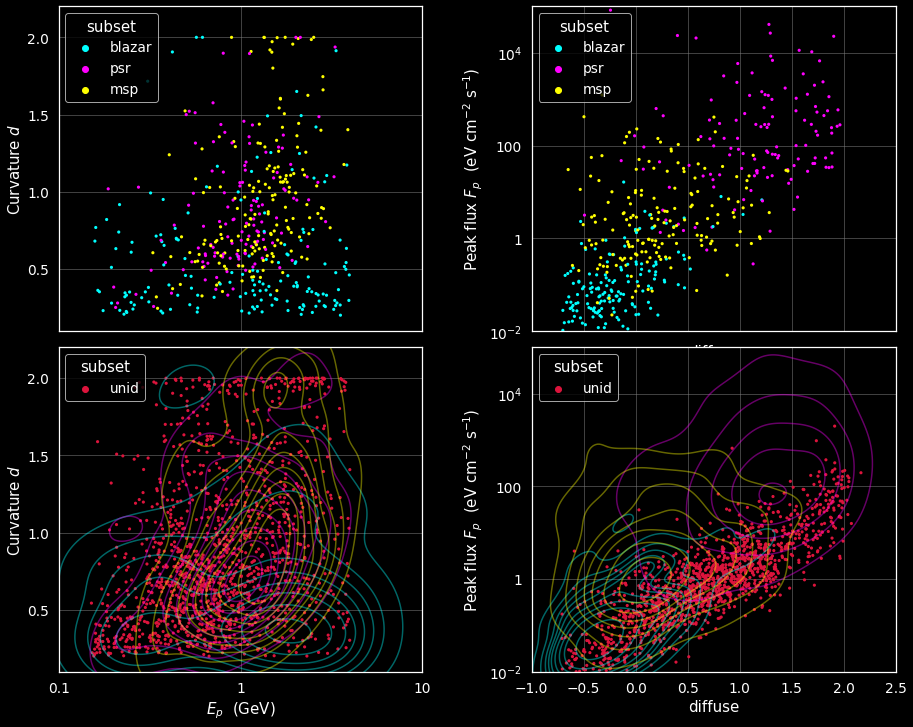

In [5]:
show_fig(plot_kde_density,self, dfc, hue_order=['unid'], palette=['crimson'])


### unid

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabf83af700>
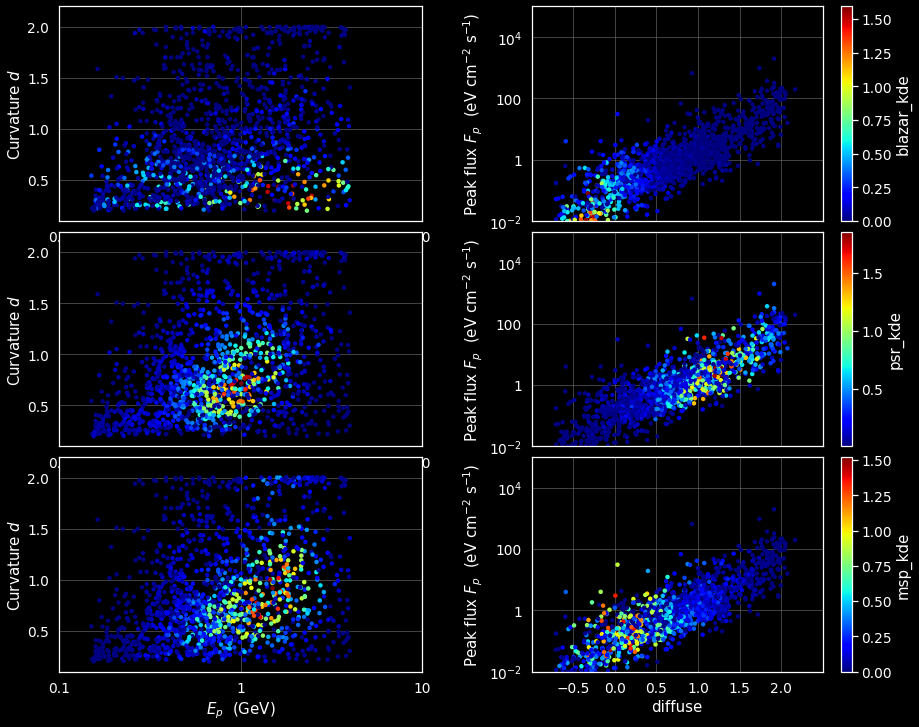

### bcu

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabcff028c0>
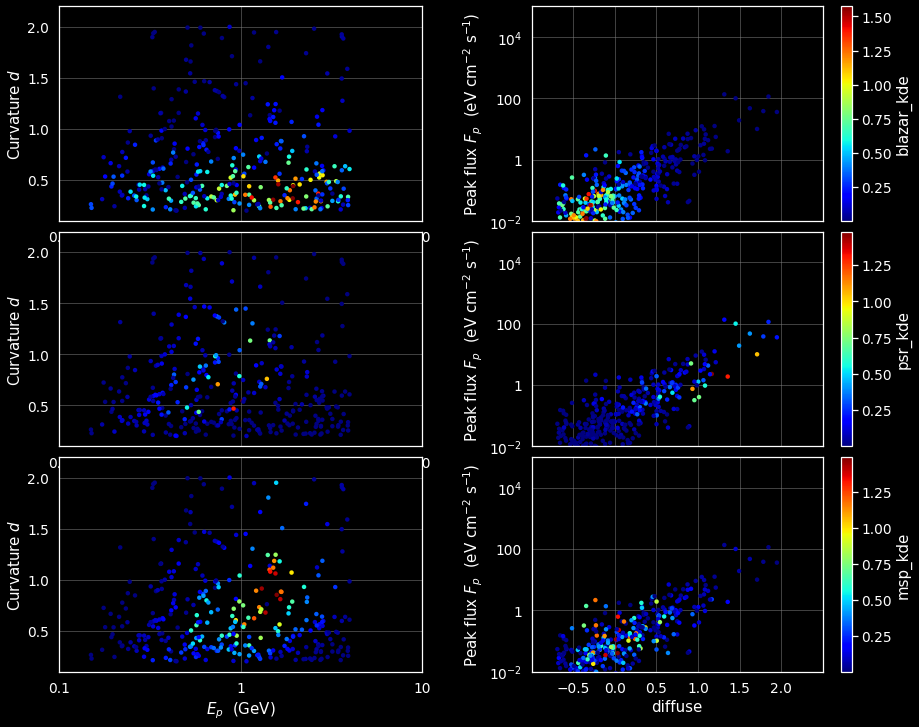

In [6]:
def data_scats(df, axx, which='unid', kde='blazar', cmap='jet'):
    ax1, ax2 = axx
    # fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1,  figsize=(12,5),  
    #                                 gridspec_kw=dict(wspace=0.3,hspace=0.05))
    data = df.query(f'subset=="{which}"')
    assert len(data)>0, f'No data selected with {which}'
    c =  data[kde+'_kde'] 
    data_kw = dict(data=data,
                  s=20, edgecolor='none', c=c, cmap=cmap,# color='maroon', 
                  label=which) 
    
    ax1.scatter( x='log_epeak', y='d',       **data_kw)
    scat = ax2.scatter( y='log_fpeak', x='diffuse', **data_kw);
    
    ax1.set(**epeak_kw(), xlim=(-1,1), ylim=(0.1,2.2),
           yticks=np.arange(0.5,2.1,0.5), ylabel='Curvature ${d}$' )
    ax2.set( **fpeak_kw('y'), xlim=(-1,2.5), xticks=np.arange(-0.5,2.1,0.5),
           xlabel='diffuse')
    # ax1.legend(); ax2.legend();
    cb= plt.colorbar(scat)
    cb.set_label(kde+'_kde')
    return fig 

def multi_scats(df, which, cmap):
    fig, axx = plt.subplots(ncols=2, nrows=3,  figsize=(15,12), sharex=False,  
                                    gridspec_kw=dict(wspace=0.3,hspace=0.05))
    data_scats(df, axx[0,:], which=which, kde='blazar')
    data_scats(df, axx[1,:], which=which,kde='psr')
    data_scats(df, axx[2,:], which=which,kde='msp')
    show(f"""### {which}""")
    return fig
    

for which in ['unid','bcu']:
    show_fig(multi_scats,dfc, which, 'jet')
    


## Emphasize the outliers

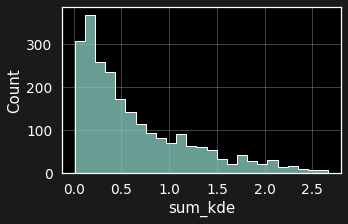

In [222]:
dfc['sum_kde'] = dfc.iloc[:,-3:].sum(axis=1)
show(f"""## Emphasize the outliers""")
which = 'unid'
# data = dfc.query(f'subset=="{which}"')['Ep d diffuse blazar_kde msp_kde psr_kde'.split()]
# data['sum_kde'] = data.iloc[:,-3:].sum(axis=1)
sns.histplot(dfc, x='sum_kde', bins=25, element='step', edgecolor='w');


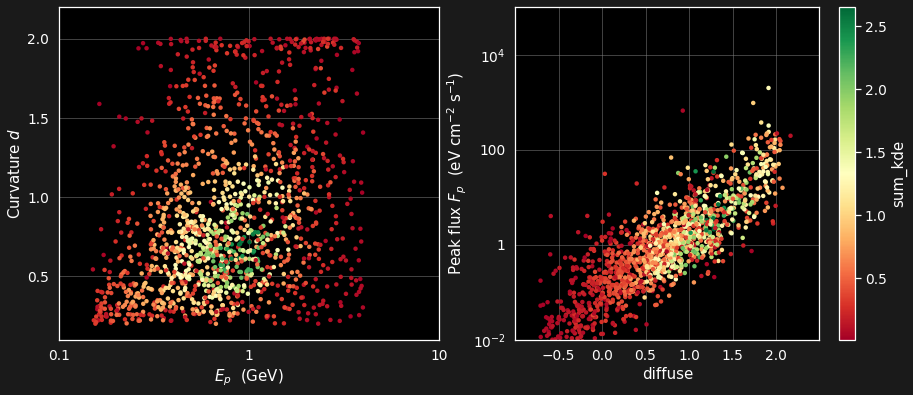

In [8]:
fig, axx = plt.subplots(ncols=2, figsize=(15,6))
data_scats(dfc, axx, which='unid', kde='sum', cmap='RdYlGn');

## Look at $d$ vs the diffuse correlation parameter 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabcff02e90>
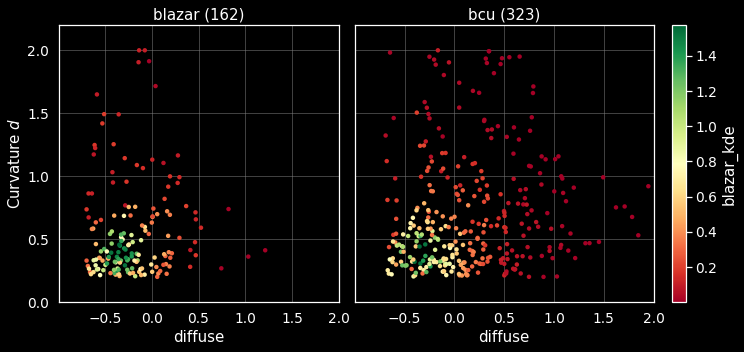

In [9]:
def d_vs_diffuse(df, ax=None, which='bcu', kde='blazar', colorbar=True):
    
    fig, ax = plt.subplots(figsize=(8,6)) if ax is None else (ax.figure, ax)
    data = dfc.query(f'subset=="{which}"')
    
    assert len(data)>0, f'No data selected with {which}'
    data_kw = dict(data=data,
                  s=20, edgecolor='none',c=data[kde+'_kde'], cmap='RdYlGn',# color='maroon', 
                  label=which) 
    ax.set( ylim=(0.,2.2),
           yticks=np.arange(0.,2.1,0.5), ylabel='Curvature ${d}$' if not colorbar else '' )
    ax.set(xlim=(-1,2.), xticks=np.arange(-0.5,2.1,0.5),  xlabel='diffuse',
          title=f'{which} ({len(data)})')
    scat = ax.scatter( x='diffuse', y='d',       **data_kw)
    if colorbar:
        cb =plt.colorbar(scat)
        cb.set_label(kde+'_kde')
        
    return fig

show(f"""## Look at $d$ vs the diffuse correlation parameter """)
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5), sharey=True, width_ratios=(3,4),
                             gridspec_kw=dict(wspace=0.05))
d_vs_diffuse( dfc, ax2, 'bcu', colorbar=True)
d_vs_diffuse( dfc, ax1, 'blazar', colorbar=False)
show(fig)

In [221]:
show("""# LR study:

<br> From the [4FGL paper](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/4FGL_Catalog_accepted.pdf):
>Because the surveys include a large number
 of Galactic sources at low Galactic latitudes, the class
 of |b| < 10◦ sources associated solely via the LR-method
 has been set to UNK (standing for unknown) as opposed
 to the BCU class used by default for sources at higher
 latitudes.

* Load 4FGL-DR4 catalog and get association info
""")
def add_assinfo(df):
    from pylib.catalogs import Fermi4FGL
    global fgl
    if 'fgl' not in globals(): fgl = Fermi4FGL()
    bay,lr = [fgl.field(t).astype(float).clip(0.,1) for t in 'ASSOC_PROB_BAY ASSOC_PROB_LR'.split()]
    df = fgl.copy()
    df['Bayes']= bay; 
    df['LR'] = lr
    df.Bayes[pd.isna(fgl_df.Bayes)]=0.5
    for name in 'RA_Counterpart DEC_counterpart Unc_Counterpart'.split():
        df[name.lower()] = fgl.field(name).astype(np.float32)
add_assinfo(fgl_df)
    

qlr, qbay =  (fgl_df.LR>0.8) , (fgl_df.Bayes>0.8)

def lr_stats(data):
    qlr, qbay =  (data.LR>0.8) , (data.Bayes>0.8)
    return pd.Series(dict(LR =sum(  qlr & ~qbay), 
                        Bayes=sum( ~qlr &  qbay),
                        both= sum(  qlr &  qbay), 
                        neither = sum(~qlr & ~qbay),  
                        total=len(data)),name='# sources')
show(f"""Association type  stats for all {len(fgl)} sources""")
show(lr_stats(fgl_df))

show(f""" ### LR-only""")
t=fgl_df[qlr & ~qbay]
show(f"Total: {len(t)}")
show("""CLASS1 values for LR-only:""")
show(pd.Series(t.groupby('class1').size(), name='LR only'))

show(f"""### Null Bayes""")
fgl_nan_bayes = fgl_df.query('Bayes==0.5'); 
show(f""" Tota: {len(fgl_nan_bayes)}""")
show(pd.Series(fgl_nan_bayes.groupby('class1').size(), name='nan Bayes'))

# LR study:

<br> From the [4FGL paper](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/8yr_catalog/4FGL_Catalog_accepted.pdf):
>Because the surveys include a large number
 of Galactic sources at low Galactic latitudes, the class
 of |b| < 10◦ sources associated solely via the LR-method
 has been set to UNK (standing for unknown) as opposed
 to the BCU class used by default for sources at higher
 latitudes.

* Load 4FGL-DR4 catalog and get association info

Association type  stats for all 7195 sources

,LR,Bayes,both,neither,total
# sources,329,1411,2808,2647,7195


### LR-only

Total: 329

CLASS1 values for LR-only:

class1,bcu,bin,bll,css,fsrq,gal,hmb,lmb,rdg,unk
LR only,152,3,19,1,8,1,1,1,3,140


### Null Bayes

Tota: 278

class1,,GAL,PWN,RDG,SFR,SNR,SPP,bcu,bin,bll,fsrq,lmb,psr,pwn,snr,spp
nan Bayes,20,2,13,2,3,26,6,139,6,39,2,6,1,3,3,7


In [32]:
has_unc = fgl_df[~pd.isna(fgl_df.unc_counterpart)]
show(len(has_unc))
has_unc.groupby('class1').size()
# sns.histplot(has_unc, x='unc_counterpart');
# sns.histplot(fgl_df, x='unc_counterpart');

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabc91ace20>

class1
          314
AGN         1
BCU         1
BIN         1
BLL        22
FSRQ       44
GAL         2
GC          1
HMB         8
LMB         2
MSP       138
NLSY1       4
NOV         8
PSR       137
PWN        12
RDG         6
SFR         3
SNR        24
agn         7
bcu      1626
bin         9
bll      1465
css         6
fsrq      776
gal         4
glc        34
hmb         3
lmb         7
msp        30
nlsy1       4
psr         2
pwn         9
rdg        47
sbg         8
sey         3
sfr         3
snr        19
spp       118
ssrq        2
unk       147
dtype: int64

In [36]:
to_kent = has_unc.query('(class1=="bcu" | class1=="unk") & 0.15<Ep<4 & d>0.2 & variability<25 '); len(to_kent)

UndefinedVariableError: name 'Ep' is not defined

In [37]:
has_unc.columns

Index(['ra', 'dec', 'glat', 'glon', 'r95', 'specfunc', 'pivot', 'eflux',
       'significance', 'variability', 'curvature', 'curv_unc', 'flags',
       'assoc_prob', 'assoc1_name', 'class1', 'Bayes', 'LR', 'ra_counterpart',
       'dec_counterpart', 'unc_counterpart'],
      dtype='object')

In [20]:
fgl.data.columns

ColDefs(
    name = 'Source_Name'; format = '18A'
    name = 'DataRelease'; format = 'I'
    name = 'RAJ2000'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'DEJ2000'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'GLON'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'GLAT'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_SemiMajor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_SemiMinor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_68_PosAng'; format = 'E'; unit = 'deg'; disp = 'F8.3'
    name = 'Conf_95_SemiMajor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_95_SemiMinor'; format = 'E'; unit = 'deg'; disp = 'F8.4'
    name = 'Conf_95_PosAng'; format = 'E'; unit = 'deg'; disp = 'F8.3'
    name = 'ROI_num'; format = 'I'
    name = 'Extended_Source_Name'; format = '18A'
    name = 'Signif_Avg'; format = 'E'; disp = 'F8.3'
    name = 'Pivot_Energy'; format = 'E'; unit = 'MeV'; disp = 'F10.2'
    name = 'Flu

## Examine BCU and UNK associations

### bcu:

,LR,Bayes,both,neither,total
# sources,152,534,801,139,1626


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabcfe873d0>
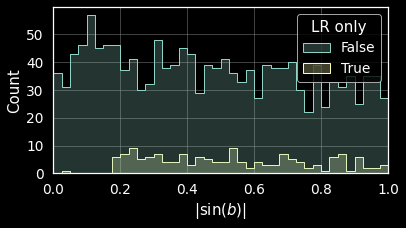

### unk:

,LR,Bayes,both,neither,total
# sources,140,0,7,0,147


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fabf8a7b400>
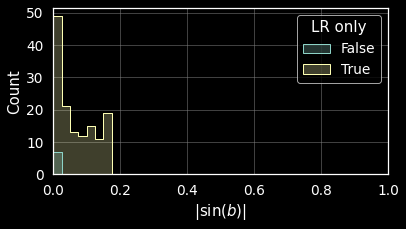

In [19]:
show(f"""## Examine BCU and UNK associations""")

def lr_plots(df, cls):
    data = df.query(f'class1=="{cls}"')
    lr_info = lr_stats(data)
    show(f"### {cls}:")
    show(lr_info)
    # sns.jointplot(data, x='Bayes', y='LR', s=5, height=6,# c='glat',
    #              marginal_kws=dict(bins=50, element='step'));        
    # show(plt.gcf())
    
    data['LR only'] = (data.LR>0.8) & (data.Bayes<0.8)
    fig, ax = plt.subplots(figsize=(6,3))
    sns.histplot(data, ax=ax, x=np.abs(np.sin(np.radians(data.glat))), hue='LR only', 
                 element='step', bins=np.arange(0,1.01,0.025));
    ax.set(xlabel=r'$|\sin(b)|$', xlim=(0,1));
    show( fig)
lr_plots(fgl_df, 'bcu')
lr_plots(fgl_df, 'unk')


In [ ]:
dfx=dfc.copy()
dfx['Bayes'] = fgl_df.loc[np.isin(fgl_df.index, dfx.index),'Bayes']
dfx['LR'] = fgl_df.loc[np.isin(fgl_df.index, dfx.index),'LR']
# dfx.Bayes[pd.isna(dfx.Bayes)]=
lr_plots(dfx, 'bcu')

In [ ]:
dfc.groupby('class1').size()

In [ ]:
def fluxticks(x, ):
    ticks =  np.arange(0,2.1,1).astype(int)
    # energy = 900 if not hasattr(self, 'energy') else self.energy
    # unit = '' if not hasattr(self, 'unit') else f'({self.unit})'
    return {x+'ticks':ticks,
            x+'ticklabels' : [f'$10^{{{x}}}$' for x in ticks],
            x+'label': f'Diffuse energy flux'}# at {energy:.0f} MeV {unit}' }

def plot_limits(self, ax, n=50, **kwargs):
    self.check_hpm()

    def ecdf(x, n=None, xlim=None):
        """Return empirical cumulative distribution function
        Parameters
        - x input array
        - n -- number of x, y values to return for sampling mode
        - xlim -- x limits: use min,max of x if NOne
        returns:
            x, y
        """
        xs = np.sort(x)
        ys = np.arange(1, len(xs)+1)/float(len(xs))
        if n is None:
            return xs, ys
        # a,b = xlim if xlim is not None else x.min
        if xlim is None:  a,b = x.min(), x.max()
        else: a,b = xlim # xfull.min(), xfull.max()# if xlim is not None else xlim
        xrange = np.arange(a, b, (b-a)/n);
        idx = np.searchsorted(xs[:-1], xrange); 
        yrange = ys[idx]
        return xrange, yrange
    
    dfm= self.diffuse_hpm.map
    x1, y1 = ecdf(dfm, n, )
    dfmx= self.diffuse_hpm.map[self.ridge_mask]
    x2, y2 = ecdf(dfmx, n, xlim=(dfm.min(),dfm.max()))   
    
    kw = dict(color='0.5', alpha=0.6)
    kw.update(kwargs)
    ax.fill_between(x1, y1, y2, **kw );
    
def plot_diffuse_flux(self,   figsize=(8,8),  df=None, unid=False,  **kwargs):
    """Distributions of diffuse energy flux background values for the source types shown.
    Upper plot: histogram with overlaid KDE curves. Lower plot: corresponding cumulative empirical distribution functions.
    The gray area shows the range between an isotropic distribution and a uniform sampling of the Galactic ridge.
    """
    data = getattr(self, 'df', None) if df is None else df 
    
    if unid:
        hkw = dict(hue='source_type',
                hue_order = ['unid-'+ name for name in self.target_names],
                palette=self.palette)    
    else:
        hkw = self.hue_kw.copy()
        hkw.pop('edgecolor', '')
        hkw.update(kwargs)
    x='diffuse'

    fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=figsize, sharex=True,
                                gridspec_kw=dict(hspace=0.1))

    sns.histplot(data, ax=ax1, bins=25, kde=True, element='step', x=x,  **hkw, )
    # update_legend(ax1, data, hkw['hue'], fontsize=12)
    ax1.set(**fluxticks('x') )
    
    sns.ecdfplot(data, ax=ax2, x=x, legend=False,  **hkw)
    # self.plot_limits( ax2, color='0.3')
    ax2.set(**fluxticks('x') )
    return fig
show_fig(plot_diffuse_flux,self, df=dfc)

In [ ]:
self

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=figsize, sharex=True,
                            gridspec_kw=dict(hspace=0.1))
data=dfc
hkw = self.hue_kw.copy()
# hkw.update(hue=
sns.histplot(data, ax=ax1, bins=25, kde=True, element='step', x=x,  **hkw, )
# update_legend(ax1, data, hkw['hue'], fontsize=12)
ax1.set(**self.fluxticks('x') )

sns.ecdfplot(data, ax=ax2, x=x, legend=False,  **hkw)
self.plot_limits( ax2, color='0.3')
ax2.set(**self.fluxticks('x') )

In [ ]:
self.hue_kw

In [ ]:
t = dfc.association=='bcu'
show(sum(t))
dfc.group

dfc.groupby('association').size()

In [ ]:
dfc.loc[dfc.association=='bcu', 'group']= 'bcu'

In [ ]:
from pylib.diffuse import Diffuse
diff = Diffuse()

In [ ]:
diff.hue_kw=dict(hue='group', hue_order='bcu blazar psr msp'.split())

In [ ]:
plt.style.use('dark_background') #s
plt.rcParams['grid.color']='0.5'

diff.plot_diffuse_flux(df=dfc);

In [ ]:
sns.histplot(data=dfc, x=np.abs(np.sin(np.radians(dfc.glat) )),
            element='step', bins=np.arange(0,1,0.05),
            hue='group', hue_order='blazar psr bcu'.split());

In [ ]:
3.25/1.6